In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
def show_model(support_array, columns, model, test_data, test_labels):
    y_pred = model.predict(test_data.iloc[:, support_array])
    r2 = r2_score(test_labels, y_pred)
    n = len(y_pred) #size of test set
    p = len(model.coef_) #number of features
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    print('Adjusted R-squared: %.2f' % adjusted_r2)
    j = 0;
    for i in range(len(support_array)):
        if support_array[i] == True:
            print(columns[i], model.coef_[j])
            j +=1

In [3]:
df = pd.read_csv('data.csv')

# Cleaning the dataset

In [4]:
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [5]:
# Dropping Null and Duplicates
df = df[df['Engine Fuel Type'].notna()]
df = df[df['Engine HP'].notna()]
df = df[df['Engine Cylinders'].notna()]
df = df[df['Number of Doors'].notna()]
df.drop(df.loc[df['Transmission Type']=='UNKNOWN'].index, inplace=True)
df['AVG_MPG'] = ((df['highway MPG']+df['city mpg']) //2)
df.drop(['highway MPG', 'city mpg'], axis = 1,inplace=True)
df.drop_duplicates(inplace=True)
number_of_duplicates= len(df)-len(df.drop_duplicates())
number_of_duplicates
# df

0

In [6]:
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        0
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category      3353
Vehicle Size            0
Vehicle Style           0
Popularity              0
MSRP                    0
AVG_MPG                 0
dtype: int64

In [7]:
df.rename(columns={'Engine Fuel Type' : 'Fuel_type', 'Engine HP':'Horsepower','Engine Cylinders':'Engine_cylinders',
'Transmission Type':'Transmission_type','Driven_Wheels':'Driven_wheels','Number of Doors':'Doors_number',
'Market Category':'Market_category','Vehicle Size':'Vehicle_size','Vehicle Style':'Vehicle_style', 
},inplace=True)

In [8]:
no_outliers_df = df[(np.abs(stats.zscore(df[['Horsepower', 'Engine_cylinders', 'AVG_MPG','MSRP']])) < 2).all(axis=1)]

In [9]:
no_outliers_df.describe()

,Year,Horsepower,Engine_cylinders,Doors_number,Popularity,MSRP,AVG_MPG
count,10241.000000,10241.000000,10241.000000,10241.000000,10241.000000,10241.000000,10241.000000
mean,2010.487159,238.043257,5.492628,3.487745,1560.601504,32023.495362,22.415584
std,7.381066,83.579881,1.429382,0.852885,1453.833639,20829.192089,5.029884
min,1990.000000,55.000000,3.000000,2.000000,21.000000,2000.000000,11.000000
25%,2007.000000,170.000000,4.000000,3.000000,549.000000,20980.000000,19.000000
50%,2015.000000,228.000000,6.000000,4.000000,1385.000000,29775.000000,22.000000
75%,2016.000000,295.000000,6.000000,4.000000,2009.000000,40635.000000,26.000000
max,2017.000000,469.000000,8.000000,4.000000,5657.000000,161070.000000,36.000000


In [10]:
# Setting X&y and splitting the DataFrame
no_outliers_df= pd.get_dummies(no_outliers_df, columns=['Fuel_type','Transmission_type','Driven_wheels','Vehicle_size'])
X= no_outliers_df.copy().drop(['MSRP','Make','Model','Market_category', 'Vehicle_style','Popularity'], axis=1)
y= no_outliers_df['MSRP']

In [12]:
# Normalizing X
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.27, random_state=1)
scaler= StandardScaler()
norm_train_X = pd.DataFrame(scaler.fit_transform(train_X), index=train_X.index, columns=train_X.columns)
norm_test_X = pd.DataFrame(scaler.fit_transform(test_X), index=test_X.index, columns=test_X.columns)

In [13]:
regr = LinearRegression()
for i in range(1, 11):
    selector = RFE(regr, n_features_to_select=i, step=1) 
    selector.fit(norm_train_X, train_y)
    print ("Model " + str(i))
    show_model(selector.support_, norm_train_X.columns, selector.estimator_, norm_test_X, test_y)
    print ("------------")

Model 1
Adjusted R-squared: 0.59
Horsepower 15990.407351125647
------------
Model 2
Adjusted R-squared: 0.67
Year 6257.657956447702
Horsepower 13520.137571530531
------------
Model 3
Adjusted R-squared: 0.69
Year 5654.116426299336
Horsepower 12222.50634646206
Fuel_type_regular unleaded -3454.9830115243512
------------
Model 4
Adjusted R-squared: 0.72
Year 5678.4569840020495
Horsepower 12170.159766651215
Fuel_type_flex-fuel (unleaded/E85) -3530.908660233573
Fuel_type_regular unleaded -4886.3678182300955
------------
Model 5
Adjusted R-squared: 0.74
Year 6116.505251407186
Horsepower 11551.299417418988
Fuel_type_flex-fuel (unleaded/E85) -5183.233035859822
Fuel_type_premium unleaded (recommended) -4240.826917009998
Fuel_type_regular unleaded -7837.304892194534
------------
Model 6
Adjusted R-squared: 0.74
Year 6035.274511830927
Horsepower 12201.569450042642
Fuel_type_flex-fuel (unleaded/E85) -4973.608535965495
Fuel_type_premium unleaded (recommended) -4213.672406145417
Fuel_type_regular un

In [33]:
# Using model 8 for the analysis 
featuress = X[['Year', 'Horsepower','Fuel_type_flex-fuel (unleaded/E85)', 
               'Fuel_type_premium unleaded (recommended)', 'Fuel_type_regular unleaded', 
             'Transmission_type_MANUAL','Driven_wheels_rear wheel drive','Vehicle_size_Compact']]

In [15]:
train_Xx, test_Xx, train_y, test_y = train_test_split(featuress, y, test_size=0.26, random_state=1)
regr.fit(train_Xx,train_y)
print('intercept ', regr.intercept_)
print(pd.DataFrame({'final features': test_Xx.columns, 'coefficient': regr.coef_}))

intercept  -1488855.2316928664
                             final features   coefficient
0                                      Year    745.196675
1                                Horsepower    150.668859
2        Fuel_type_flex-fuel (unleaded/E85) -17650.075979
3  Fuel_type_premium unleaded (recommended) -12529.747319
4                Fuel_type_regular unleaded -16154.122128
5                  Transmission_type_MANUAL  -2799.322581
6            Driven_wheels_rear wheel drive  -2139.430713
7                      Vehicle_size_Compact   3808.463290


In [16]:
# Predicting a Car Price with these values for the selected 4 features.
print('$',round(float(regr.predict([[2010,160,0,1,0,0,1,0]])),2))

$ 18427.93


In [17]:
predited=regr.predict(test_Xx)
print('The accuracy of this prediction is %' + str(round((r2_score(test_y,predited)*100))))

The accuracy of this prediction is %75


# Classification Extra Credit

In [18]:
no_outliers_df.head(5)
pd.options.display.max_columns = None

,Year,Horsepower,Engine_cylinders,Doors_number,AVG_MPG,Fuel_type_diesel,Fuel_type_flex-fuel (premium unleaded recommended/E85),Fuel_type_flex-fuel (premium unleaded required/E85),Fuel_type_flex-fuel (unleaded/E85),Fuel_type_natural gas,Fuel_type_premium unleaded (recommended),Fuel_type_premium unleaded (required),Fuel_type_regular unleaded,Transmission_type_AUTOMATED_MANUAL,Transmission_type_AUTOMATIC,Transmission_type_MANUAL,Driven_wheels_all wheel drive,Driven_wheels_four wheel drive,Driven_wheels_front wheel drive,Driven_wheels_rear wheel drive,Vehicle_size_Compact,Vehicle_size_Large,Vehicle_size_Midsize
0,2011,335.0,6.0,2.0,22,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0
1,2011,300.0,6.0,2.0,23,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0
2,2011,300.0,6.0,2.0,24,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0
3,2011,230.0,6.0,2.0,23,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0
4,2011,230.0,6.0,2.0,23,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,2012,300.0,6.0,4.0,19,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
11910,2012,300.0,6.0,4.0,19,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
11911,2012,300.0,6.0,4.0,19,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
11912,2013,300.0,6.0,4.0,19,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1


In [19]:
fourandeight = no_outliers_df.copy()
# fourandeight.drop(fourandeight[fourandeight['Engine_cylinders']df.drop(df[df.score < 50].index)
# df.drop(df[df.score < 50].index)
fourandeight.drop(fourandeight[fourandeight.Engine_cylinders== 3.0].index, inplace=True)
fourandeight.drop(fourandeight[fourandeight.Engine_cylinders== 5.0].index, inplace=True)
fourandeight.drop(fourandeight[fourandeight.Engine_cylinders== 6.0].index, inplace=True)

Classification_X =fourandeight[['Year','Horsepower','AVG_MPG', 'Doors_number','MSRP']]
# fourandeight= no_outliers_df[(no_outliers_df.Engine_cylinders != 5.0) & (no_outliers_df.Engine_cylinders != 3.0)
#                & (no_outliers_df.Engine_cylinders != 6.0)]
Classification_y = fourandeight['Engine_cylinders'] 


Changing the Values of 4 cylinders to 0 and 8 cylinders to 1

In [20]:
Classification_y.loc[fourandeight.Engine_cylinders == 4.0] = 0
Classification_y.loc[fourandeight.Engine_cylinders == 8.0] = 1

C:\Users\Besho\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Besho\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [21]:
round(Classification_y.value_counts()/len(Classification_y),2)

0.0    0.71
1.0    0.29
Name: Engine_cylinders, dtype: float64

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(Classification_X, Classification_y, test_size=.3,
                                                    random_state=0)

In [23]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,Y_train)
y_pred = cross_val_predict(clf, Classification_X, Classification_y, cv=10)
cm = confusion_matrix(Classification_y, y_pred)
print(cm)
print (classification_report(Classification_y,y_pred))

[[4088   68]
 [  51 1611]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      4156
         1.0       0.96      0.97      0.96      1662

    accuracy                           0.98      5818
   macro avg       0.97      0.98      0.98      5818
weighted avg       0.98      0.98      0.98      5818



In [24]:
#pruning the tree
clf = tree.DecisionTreeClassifier(max_depth=15,
    min_samples_split=2,
    min_samples_leaf=5,)
clf.fit(X_train,Y_train)
clf_y_pred = cross_val_predict(clf, Classification_X, Classification_y, cv=10)
cm = confusion_matrix(Classification_y, clf_y_pred)
print(cm)
print (classification_report(Classification_y,clf_y_pred))

[[4099   57]
 [  36 1626]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4156
         1.0       0.97      0.98      0.97      1662

    accuracy                           0.98      5818
   macro avg       0.98      0.98      0.98      5818
weighted avg       0.98      0.98      0.98      5818



In [25]:
#Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=1)
rf_clf.fit(X_train, Y_train)
rf_y_pred = cross_val_predict(rf_clf, Classification_X, Classification_y, cv=10)
cm = confusion_matrix(Classification_y, rf_y_pred)
print(cm)
print (classification_report(Classification_y,rf_y_pred))

[[4110   46]
 [  54 1608]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4156
         1.0       0.97      0.97      0.97      1662

    accuracy                           0.98      5818
   macro avg       0.98      0.98      0.98      5818
weighted avg       0.98      0.98      0.98      5818



In [26]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_y_pred = cross_val_predict(nb, Classification_X, Classification_y, cv=10)
cm = confusion_matrix(Classification_y, nb_y_pred)
print(cm)
print (classification_report(Classification_y,rf_y_pred))

[[4095   61]
 [  30 1632]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4156
         1.0       0.97      0.97      0.97      1662

    accuracy                           0.98      5818
   macro avg       0.98      0.98      0.98      5818
weighted avg       0.98      0.98      0.98      5818



In [27]:
rf_prob = rf_clf.predict_proba(X_test)
nb_prob = nb.predict_proba(X_test)
clf_prob = clf.predict_proba(X_test)
rf_prob = rf_prob[:, 1]
nb_prob = nb_prob[:, 1]
clf_prob = clf_prob[:, 1]
clf_auc = roc_auc_score(Y_test, clf_prob)
rf_auc = roc_auc_score(Y_test, rf_prob)
nb_auc = roc_auc_score(Y_test, nb_prob)
cm.ravel()
tn, fp, fn, tp=cm.ravel()

In [28]:
print('Decision Tree: AUROC = %.3f' % (clf_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))

Decision Tree: AUROC = 0.998
Random Forest: AUROC = 0.994
Naive Bayes: AUROC = 0.999


In [29]:
clf_fpr, clf_tpr, _ = roc_curve(Y_test, clf_prob)
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_prob)
nb_fpr, nb_tpr, _ = roc_curve(Y_test, nb_prob)

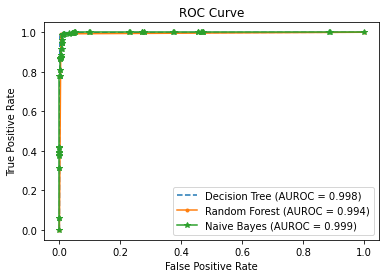

In [32]:
plt.plot(clf_fpr, clf_tpr, linestyle='--', label='Decision Tree (AUROC = %0.3f)' % clf_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='*', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()